### Import Necessary Libraries

In [1]:
from pyspark.sql import SparkSession
import pyspark.pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, TimestampType, DoubleType
from pyspark.sql.functions import to_date,from_unixtime, unix_timestamp, col, datediff, lit, array,monotonically_increasing_id
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler,VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans, BisectingKMeans
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import functions as F

C:\Users\saswa\anaconda3\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


### Creating a Spark Object

In [2]:
spark = SparkSession.builder.getOrCreate()

### Loading the Data Set 

1. As we have the header already in the dataset.
2. We have **header** as **true** in the below code, as well as initially we are letting spark object decide the schema as well, hence **infershema** is **True** as well

In [3]:
csv_file_path = r"C:\Users\saswa\OneDrive\Desktop\pruject\BankCustomerSegmentation/bank_transactions.csv"
sdf = spark.read.option("header","true").csv(csv_file_path, inferSchema = True)

### Creating a a backup data set of the original one right at the start

In [4]:
backup_df = sdf# creating a Backup

#### Changing the type of CustomerDOB as the infershcema was not able to identify the column as a DateType()

In [5]:
sdf = sdf.withColumn("CustomerDOB",sdf["CustomerDOB"].cast(DateType()))   # Converting the CustomerDOB to DateType()
sdf.show(5)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|           T1|  C5841053| 1994-01-10|         F|  JAMSHEDPUR|          17819.05|     2016-08-02|         143207|                   25.0|
|           T2|  C2142763| 1957-04-04|         M|     JHAJJAR|           2270.69|     2016-08-02|         141858|                27999.0|
|           T3|  C4417068| 1996-11-26|         F|      MUMBAI|          17874.44|     2016-08-02|         142712|                  459.0|
|           T4|  C5342380| 1973-09-14|         F|      MUMBAI|         866503.21|     2016-08-02|         142714|                 2060.0|
|           T5|  C9031234| 1988-03

#### We are creating a list of numberical columns with List Comprehension in the below step, the aim is to use the describe method on all the numerical columns

In [6]:
numeric_columns = sdf.select([col for col, dtype in sdf.dtypes if dtype == "double" or dtype == "int"])
numeric_columns.describe().show()

+-------+------------------+------------------+-----------------------+
|summary|CustAccountBalance|   TransactionTime|TransactionAmount (INR)|
+-------+------------------+------------------+-----------------------+
|  count|           1046198|           1048567|                1048567|
|   mean|115403.54005622228|157087.52939297154|       1574.33500345711|
| stddev| 846485.3806006615| 51261.85402232943|      6574.742978453988|
|    min|               0.0|                 0|                    0.0|
|    max|     1.150354951E8|            235959|             1560034.99|
+-------+------------------+------------------+-----------------------+



### We can afford to remove the NaN values, as the column with highest number of null value only consists of 5.5 percent of null values

In [7]:
null_counts = sdf.agg(*[F.sum(F.col(column).isNull().cast("int")).alias(column) for column in sdf.columns])
null_counts.show()

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|            0|         0|      60736|      1100|         151|              2369|              0|              0|                      0|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+



In [8]:
print(f"Shape before dropping the na values : ({sdf.count()},{len(sdf.columns)})")
sdf = sdf.na.drop()
print(f"Shape after dropping the na values : ({sdf.count()},{len(sdf.columns)})")
sdf.show(truncate=False)

Shape before dropping the na values : (1048567,9)
Shape after dropping the na values : (985322,9)
+-------------+----------+-----------+----------+-----------------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation           |CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+-----------------------+------------------+---------------+---------------+-----------------------+
|T1           |C5841053  |1994-01-10 |F         |JAMSHEDPUR             |17819.05          |2016-08-02     |143207         |25.0                   |
|T2           |C2142763  |1957-04-04 |M         |JHAJJAR                |2270.69           |2016-08-02     |141858         |27999.0                |
|T3           |C4417068  |1996-11-26 |F         |MUMBAI                 |17874.44          |2016-08-02     |142712         |459.0                  |
|T4     

In [9]:
sdf_cleaned=sdf

#### Here as we have the birth date, we will calculate the age of the Customer at the time he made the transaction 
#####  TransactionDate - CustomerDate = No. of days (Will give us number of days between the 2 Date Columns)
#####  No. of Days / 365 - is going to give us float of years 
#####  Casting it to the IntegerType  as the age is always said to be as a whole Number
#####  As now we are creating a correlated column of Age, we should drop the CustomerDOB column for reducing the Multicolliearity 

In [10]:
sdf = sdf.withColumn('CustomerAge', datediff('TransactionDate','CustomerDOB')/365)
sdf = sdf.withColumn('CustomerAge', col('CustomerAge').cast(IntegerType()))
sdf.show()
sdf = sdf.drop("CustomerDOB")

+-------------+----------+-----------+----------+--------------------+------------------+---------------+---------------+-----------------------+-----------+
|TransactionID|CustomerID|CustomerDOB|CustGender|        CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustomerAge|
+-------------+----------+-----------+----------+--------------------+------------------+---------------+---------------+-----------------------+-----------+
|           T1|  C5841053| 1994-01-10|         F|          JAMSHEDPUR|          17819.05|     2016-08-02|         143207|                   25.0|         22|
|           T2|  C2142763| 1957-04-04|         M|             JHAJJAR|           2270.69|     2016-08-02|         141858|                27999.0|         59|
|           T3|  C4417068| 1996-11-26|         F|              MUMBAI|          17874.44|     2016-08-02|         142712|                  459.0|         19|
|           T4|  C5342380| 1973-09-14|         F|   

### Now let us try to acheive the Encoding in a few specific columns.

##### StringIndexer comes in handy for PySpark if we need to have Numbers(Float Values) assigned to Strings
##### Again now we can go ahead and drop the CustGender Column

#### Encoding the CustGender column

In [11]:
indexer = StringIndexer(inputCol='CustGender', outputCol='GenderEncoded')
sdf = indexer.fit(sdf).transform(sdf)
sdf = sdf.withColumn('GenderEncoded', col('GenderEncoded').cast(IntegerType()))
sdf = sdf.drop("CustGender")
sdf.show()
sdf.show(truncate = False)

+-------------+----------+--------------------+------------------+---------------+---------------+-----------------------+-----------+-------------+
|TransactionID|CustomerID|        CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustomerAge|GenderEncoded|
+-------------+----------+--------------------+------------------+---------------+---------------+-----------------------+-----------+-------------+
|           T1|  C5841053|          JAMSHEDPUR|          17819.05|     2016-08-02|         143207|                   25.0|         22|            1|
|           T2|  C2142763|             JHAJJAR|           2270.69|     2016-08-02|         141858|                27999.0|         59|            0|
|           T3|  C4417068|              MUMBAI|          17874.44|     2016-08-02|         142712|                  459.0|         19|            1|
|           T4|  C5342380|              MUMBAI|         866503.21|     2016-08-02|         142714|        

In [13]:
sdf.groupBy("GenderEncoded").count().show() # To check the the distribution of Gender with respect to the number of transactions done!

+-------------+------+
|GenderEncoded| count|
+-------------+------+
|            1|272868|
|            0|712454|
+-------------+------+



#### Endcoding the CustLocation Column

In [14]:
indexer_location = StringIndexer(inputCol='CustLocation', outputCol='LocationEncoded')
sdf = indexer_location.fit(sdf).transform(sdf)
sdf = sdf.withColumn('LocationEncoded', col('LocationEncoded').cast(IntegerType()))
sdf = sdf.drop("CustLocation")
sdf.show()

+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+
|TransactionID|CustomerID|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustomerAge|GenderEncoded|LocationEncoded|
+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+
|           T1|  C5841053|          17819.05|     2016-08-02|         143207|                   25.0|         22|            1|             61|
|           T2|  C2142763|           2270.69|     2016-08-02|         141858|                27999.0|         59|            0|            106|
|           T3|  C4417068|          17874.44|     2016-08-02|         142712|                  459.0|         19|            1|              0|
|           T4|  C5342380|         866503.21|     2016-08-02|         142714|                 2060.0|         42|            1|         

In [15]:
ip_columns = ['CustAccountBalance', 'TransactionTime','TransactionAmount (INR)','CustomerAge','LocationEncoded','GenderEncoded']
# Assemble features into a Vector column
assembler = VectorAssembler(inputCols=ip_columns, outputCol="features")
df = assembler.transform(sdf)


scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features") # Initialize the MinMaxScaler

# Fit and transform the data using the scaler
scaler_model = scaler.fit(df)
scaled_df = scaler_model.transform(df)

# Show the scaled data
scaled_df.show(truncate=False)



+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+-----------------------------------------+-------------------------------------------------------------------------------------------------------------+
|TransactionID|CustomerID|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustomerAge|GenderEncoded|LocationEncoded|features                                 |scaled_features                                                                                              |
+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+-----------------------------------------+-------------------------------------------------------------------------------------------------------------+
|T1           |C5841053  |17819.05          |2016-08-02     |143207         |25.0                   |22         

In [16]:
scaled_df.show()

+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+--------------------+--------------------+
|TransactionID|CustomerID|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustomerAge|GenderEncoded|LocationEncoded|            features|     scaled_features|
+-------------+----------+------------------+---------------+---------------+-----------------------+-----------+-------------+---------------+--------------------+--------------------+
|           T1|  C5841053|          17819.05|     2016-08-02|         143207|                   25.0|         22|            1|             61|[17819.05,143207....|[1.54900450374121...|
|           T2|  C2142763|           2270.69|     2016-08-02|         141858|                27999.0|         59|            0|            106|[2270.69,141858.0...|[1.97390379206530...|
|           T3|  C4417068|          17874.44|     2016-08-02|         

In [17]:
final_data = scaled_df.drop("CustAccountBalance","TransactionDate","TransactionTime","TransactionAmount (INR)","CustomerAge","LocationEncoded","LocationEncoded","features","TransactionID","CustomerID","GenderEncoded")

In [18]:
final_data.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                              |
+-------------------------------------------------------------------------------------------------------------+
|[1.5490045037412108E-4,0.6069147606151917,1.6025281586793128E-5,0.3535353535353536,0.007472742864143085,1.0] |
|[1.9739037920653066E-5,0.6011976656961592,0.01794767436594483,0.7272727272727273,0.012985422026215852,0.0]   |
|[1.55381953930496E-4,0.6048169385359321,2.9422416993352184E-4,0.32323232323232326,0.0,1.0]                   |
|[0.007532485597134618,0.6048254145847373,0.0013204832027517537,0.5555555555555556,0.0,1.0]                   |
|[5.8368332262691326E-5,0.7677435486673533,0.0011297823518689155,0.4141414141414142,0.001470047776552738,1.0] |
|[4.6602311706832474E-4,0.7371619645785921,4.3332361410688616E-4,0.5656565656565657,0.04079382579933848,

In [19]:
# Select the features to be used for clustering and assemble them into a vector column
feature_cols = ["scaled_features"]  # Replace with your feature column names
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(final_data)

In [20]:
data=data.drop("scaled_features")

In [21]:
data.show()

+--------------------+
|            features|
+--------------------+
|[1.54900450374121...|
|[1.97390379206530...|
|[1.55381953930496...|
|[0.00753248559713...|
|[5.83683322626913...|
|[4.66023117068324...|
|[8.46225766363481...|
|[8.26488727825712...|
|[1.29585742096745...|
|[3.71991270718667...|
|[4.20996058285317...|
|[1.27034355676885...|
|[2.80563664040769...|
|[5.21147320206561...|
|[8.78062896258182...|
|[1.11541224635456...|
|[1.89319826728854...|
|[2.85269950561546...|
|[9.25236162173043...|
|[2.55070836827301...|
+--------------------+
only showing top 20 rows



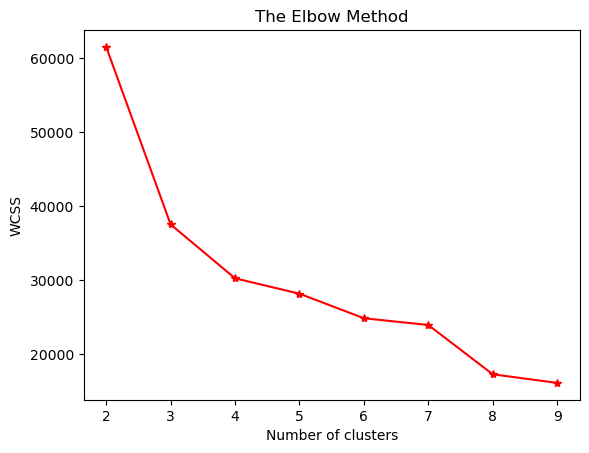

In [22]:


# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(2, 10):
    kmeans = KMeans().setK(i).setSeed(42)
    model = kmeans.fit(data)
    wcss.append(model.summary.trainingCost)  # Equivalent to Sklearns ._inertia

# Plot the Elbow Method graph
plt.plot(range(2, 10), wcss, marker='*', color='r')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


# Calculate Silhouette scores for different numbers of clusters
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]


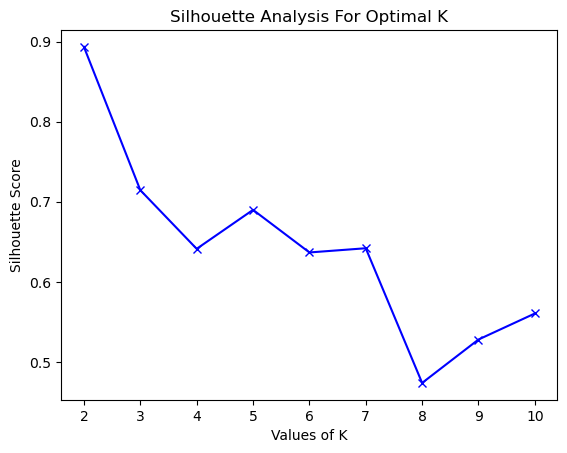

In [23]:
silhouette_scores = []
for num_clusters in range_n_clusters:
    kmeans = KMeans().setK(num_clusters).setSeed(42)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plot the Silhouette Analysis graph
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal K')
plt.show()

In [24]:
kmeans = KMeans().setK(3).setSeed(42)
model = kmeans.fit(data)
predictions = model.transform(data)

In [25]:
predictions.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.54900450374121...|         1|
|[1.97390379206530...|         2|
|[1.55381953930496...|         1|
|[0.00753248559713...|         1|
|[5.83683322626913...|         1|
|[4.66023117068324...|         1|
|[8.46225766363481...|         1|
|[8.26488727825712...|         0|
|[1.29585742096745...|         1|
|[3.71991270718667...|         0|
|[4.20996058285317...|         0|
|[1.27034355676885...|         0|
|[2.80563664040769...|         0|
|[5.21147320206561...|         1|
|[8.78062896258182...|         2|
|[1.11541224635456...|         1|
|[1.89319826728854...|         2|
|[2.85269950561546...|         2|
|[9.25236162173043...|         0|
|[2.55070836827301...|         0|
+--------------------+----------+
only showing top 20 rows



### EXPORTED TO LOCAL FILE AS CSV

In [133]:
sdf_cleaned.toPandas().to_csv(r"C:\Users\saswa\OneDrive\Desktop\DBDA\aaa\f1.csv")

In [135]:
predictions.toPandas().to_csv(r"C:\Users\saswa\OneDrive\Desktop\DBDA\aaa\f2.csv")

In [26]:
pandas_df=sdf_cleaned.to_pandas_on_spark()

In [31]:
pandas_df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,9.853220e+05,985322.000000,9.853220e+05
mean,1.060612e+05,157434.409364,1.452425e+03
std,8.179054e+05,51270.673224,6.139765e+03
min,0.000000e+00,0.000000,0.000000e+00
25%,4.580070e+03,124240.000000,1.510000e+02
50%,1.599870e+04,164622.000000,4.310000e+02
75%,5.372813e+04,200148.000000,1.125000e+03
max,1.150355e+08,235959.000000,1.560035e+06


In [36]:
df=pd.read_csv(r"C:\Users\saswa\OneDrive\Desktop\pruject\BankCustomerSegmentation\Data_with_pred.csv")

In [37]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),prediction
0,T1,C5841053,10-01-1994,F,JAMSHEDPUR,17819.05,02-08-2016,143207,25.00,1
1,T2,C2142763,04-04-1957,M,JHAJJAR,2270.69,02-08-2016,141858,27999.00,2
2,T3,C4417068,26-11-1996,F,MUMBAI,17874.44,02-08-2016,142712,459.00,1
3,T4,C5342380,14-09-1973,F,MUMBAI,866503.21,02-08-2016,142714,2060.00,1
4,T5,C9031234,24-03-1988,F,NAVI MUMBAI,6714.43,02-08-2016,181156,1762.50,1
5,T6,C1536588,08-10-1972,F,ITANAGAR,53609.20,02-08-2016,173940,676.00,1
6,T7,C7126560,26-01-1992,F,MUMBAI,973.46,02-08-2016,173806,566.00,1
7,T8,C1220223,27-01-1982,M,MUMBAI,95075.54,02-08-2016,170537,148.00,0
8,T9,C8536061,19-04-1988,F,GURGAON,14906.96,02-08-2016,192825,833.00,1
9,T10,C6638934,22-06-1984,M,MUMBAI,4279.22,02-08-2016,192446,289.11,0


### MEANINGFUL INSIGHTS

In [39]:
insights=df.groupby('prediction').mean()

In [53]:
insights.drop(columns="TransactionTime")

,CustAccountBalance,TransactionAmount (INR)
prediction,,
1,101453.040968,1598.720408
2,109649.769828,1345.038195
0,106599.888389,1430.925578


### BisectingKmeans equivalent to hierarchial clustering in ML

In [75]:
# Train a BisectingKMeans model
k = 2  # Number of clusters
bkm = BisectingKMeans().setK(k).setSeed(42)
model = bkm.fit(data)

# Transform the data with cluster assignments
clustered_data = model.transform(data)

# Display the clustered data
clustered_data.show()

+-------------+--------------------+--------------------+----------+
|GenderEncoded|     scaled_features|            features|prediction|
+-------------+--------------------+--------------------+----------+
|            1|[1.54900450374121...|[1.0,1.5490045037...|         1|
|            0|[1.97390379206530...|[0.0,1.9739037920...|         0|
|            1|[1.55381953930496...|[1.0,1.5538195393...|         1|
|            1|[0.00753248559713...|[1.0,0.0075324855...|         1|
|            1|[5.83683322626913...|[1.0,5.8368332262...|         1|
|            1|[4.66023117068324...|[1.0,4.6602311706...|         1|
|            1|[8.46225766363481...|[1.0,8.4622576636...|         1|
|            0|[8.26488727825712...|[0.0,8.2648872782...|         0|
|            1|[1.29585742096745...|[1.0,1.2958574209...|         1|
|            0|[3.71991270718667...|[0.0,3.7199127071...|         0|
|            0|[4.20996058285317...|[0.0,4.2099605828...|         0|
|            0|[1.27034355676885..